## Time Series Forecasting with Python

1. ARIMA
2. Exponential Smoothing Model
3. Prophet

In [ ]:
!pip install yfinance prophet statsmodels matplotlib pandas pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 21.6 MB/s eta 0:00:00


In [32]:
from google.colab import files
import yfinance as yf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = yf.download('AAPL', start='2015-01-01', end='2023-12-31', progress=False)

YF.download() has changed argument auto_adjust default to True


In [ ]:
df

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2015-01-02,24.320429,24.789798,23.879978,24.778675,212818400
2015-01-05,23.635294,24.169174,23.448437,24.089092,257142000
2015-01-06,23.637510,23.897776,23.274916,23.699796,263188400
2015-01-07,23.968960,24.069062,23.735387,23.846612,160423600
2015-01-08,24.889900,24.947738,24.180285,24.298185,237458000
...,...,...,...,...,...
2023-12-22,192.444595,194.243791,191.818350,194.015153,37122800
2023-12-26,191.897873,192.732856,191.679185,192.454528,28919300


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2264 entries, 2015-01-02 to 2023-12-29
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   (Close, AAPL)   2264 non-null   float64
 1   (High, AAPL)    2264 non-null   float64
 2   (Low, AAPL)     2264 non-null   float64
 3   (Open, AAPL)    2264 non-null   float64
 4   (Volume, AAPL)  2264 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 106.1 KB


In [ ]:
df.describe()

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
count,2264.000000,2264.000000,2264.000000,2264.000000,2.264000e+03
mean,81.673040,82.500388,80.763437,81.604385,1.237607e+08
std,56.182341,56.757620,55.545175,56.127500,6.818458e+07
min,20.674530,20.978911,20.475430,20.596728,2.404830e+07
25%,32.926906,33.123764,32.745146,32.939102,7.831732e+07
50%,51.395998,52.210079,51.020437,51.543365,1.056556e+08
75%,139.493019,141.184967,136.983594,139.434335,1.486811e+08
max,196.927673,198.428656,195.824294,196.838214,6.488252e+08


In [ ]:
print("No. of rows: ", df.shape[0])
print("No. of cols: ", df.shape[1])

No. of rows:  2264
No. of cols:  5


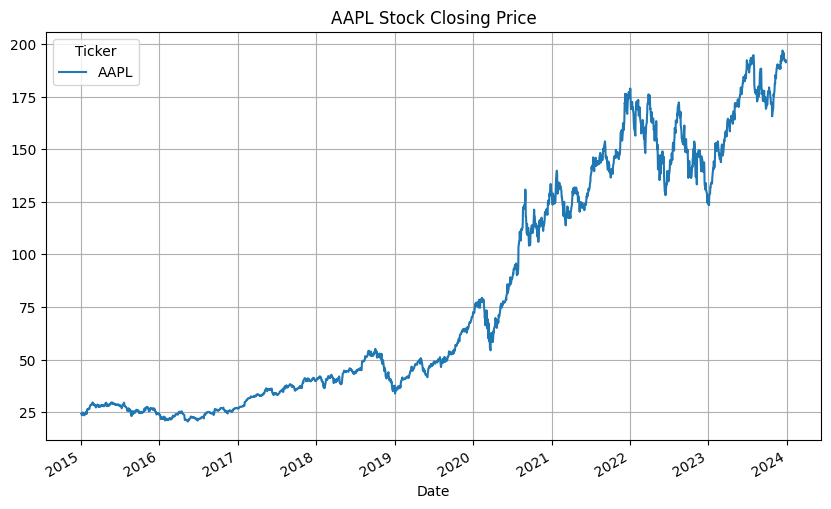

In [ ]:
df['Close'].plot(figsize=(10, 6), title="AAPL Stock Closing Price", grid=True)
plt.show()

<Figure size 1200x800 with 0 Axes>

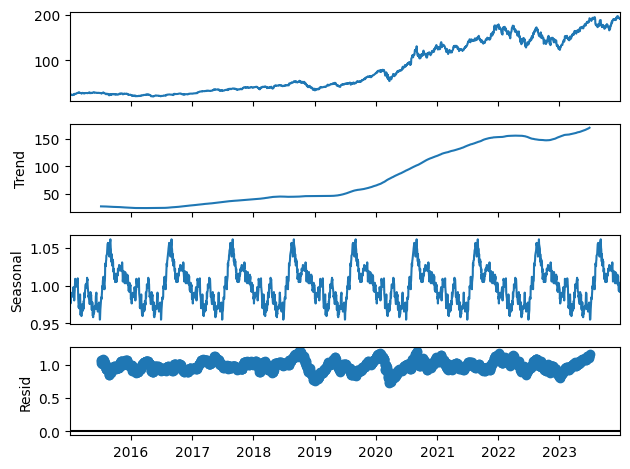

In [ ]:
decomposition = seasonal_decompose(df['Close'], model='multiplicative', period=252)
plt.figure(figsize=(12, 8))
decomposition.plot()
plt.show()

#### Time Series Forcasting

In [ ]:
df.index = pd.to_datetime(df.index)

In [ ]:
train = df['Close'][:-60]
test = df['Close'][-60:]

#### Standardize the train and test data

In [ ]:
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train.values.reshape(-1, 1)).flatten()
test_scaled = scaler.transform(test.values.reshape(-1, 1)).flatten()

#### Fit ARIMA model on scaled training data

In [ ]:
arima_model_scaled = ARIMA(train_scaled, order=(1, 1, 1))
arima_model_fit_scaled = arima_model_scaled.fit()

#### Make predictions for the next 60 days on scaled data

In [ ]:
start_index = len(train_scaled)
end_index = start_index + len(test_scaled) - 1

In [ ]:
arima_forecast_scaled = arima_model_fit_scaled.predict(start=start_index, end=end_index, type='labels')

In [ ]:
arima_forecast_rescaled = scaler.inverse_transform(arima_forecast_scaled.reshape(-1, 1)).flatten()

In [ ]:
arima_forecast_rescaled = pd.Series(arima_forecast_rescaled, index=test.index)

In [ ]:
print(f"Test NaN count: {test.isna().sum()}")
print(f"ARIMA Forecast NaN count: {pd.Series(arima_forecast_rescaled).isna().sum()}")

Test NaN count: Ticker
AAPL    0
dtype: int64
ARIMA Forecast NaN count: 0


In [ ]:
if not (pd.Series(arima_forecast_rescaled).isna().values.any()) and not (test.isna().values.any()):
    arima_mse = mean_squared_error(test, arima_forecast_rescaled)
    print(f"ARIMA Mean Squared Error: {arima_mse}")
else:
    print("ARIMA: Forecast or test contains NaN values. Unable to calculate MSE")

ARIMA Mean Squared Error: 215.23357742003384


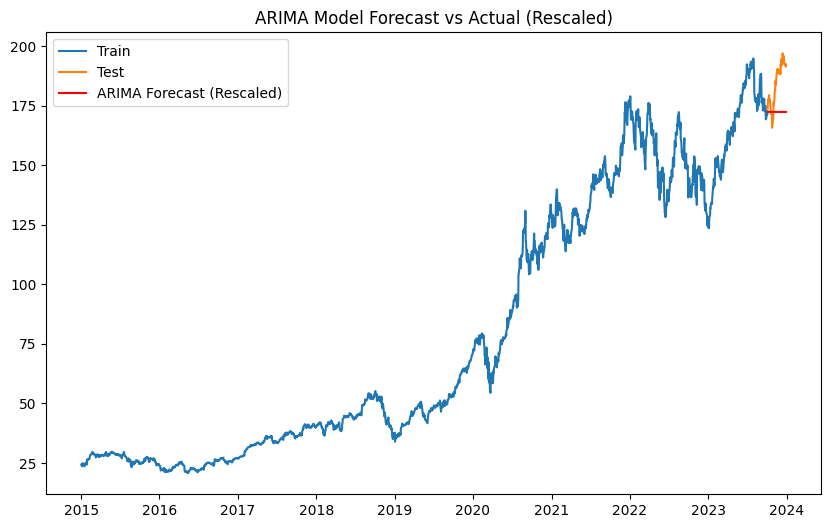

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(arima_forecast_rescaled, label='ARIMA Forecast (Rescaled)', color='red')
plt.title('ARIMA Model Forecast vs Actual (Rescaled)')
plt.legend()

#### Fit ETS model on scaled training data

In [ ]:
ets_model_scaled = ExponentialSmoothing(train_scaled, trend='additive', seasonal=None)
ets_model_fit_scaled = ets_model_scaled.fit()

#### Make predictions for the next 60 days on scaled data

In [ ]:
ets_forecast_scaled = ets_model_fit_scaled.forecast(60)

#### Rescaled the data

In [ ]:
ets_forecast_rescaled = scaler.inverse_transform(ets_forecast_scaled.reshape(-1, 1)).flatten()

#### MSE Calculation
#### Check for NaN Values in both test and forecast data

In [ ]:
ets_forecast_rescaled = pd.Series(ets_forecast_rescaled, index=test.index)

In [ ]:
print(f"Test NaN count: {test.isna().sum()}")
print(f"ARIMA Forecast NaN count: {pd.Series(ets_forecast_rescaled).isna().sum()}")

Test NaN count: Ticker
AAPL    0
dtype: int64
ARIMA Forecast NaN count: 0


#### Calculate ETS MSE if valid data point exist

In [ ]:
if not (pd.Series(ets_forecast_rescaled).isna().values.any()) and not (test.isna().values.any()):
    ets_mse = mean_squared_error(test, ets_forecast_rescaled)
    print(f"ETS Mean Squared Error: {ets_mse}")
else:
    print("ETS: Forecast or test contains NaN values. Unable to calculate MSE")

ETS Mean Squared Error: 154.07567371315872


#### Plot the ETS Forecast vs Actual

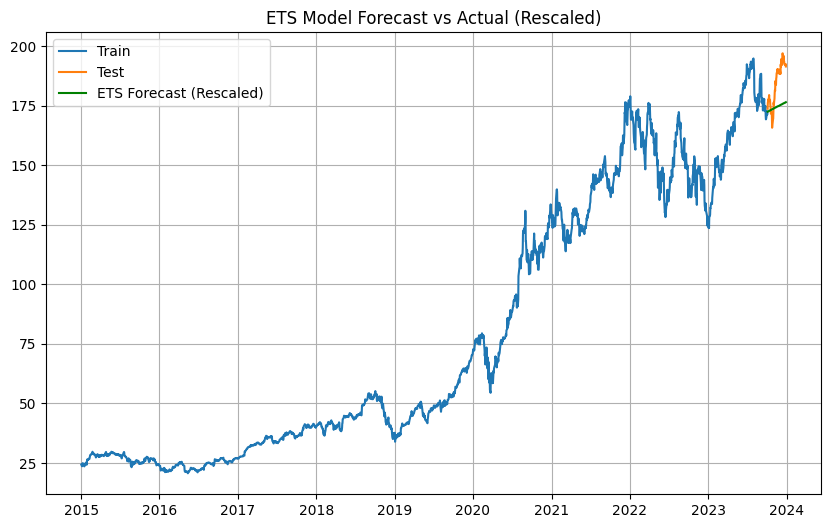

In [31]:
plt.figure(figsize=(10, 6))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(ets_forecast_rescaled, label='ETS Forecast (Rescaled)', color='green')
plt.title('ETS Model Forecast vs Actual (Rescaled)')
plt.grid(True)
plt.legend()

### Model 3: Prophet

In [36]:
train

Ticker,AAPL
Date,
2015-01-02,24.320429
2015-01-05,23.635294
2015-01-06,23.637510
2015-01-07,23.968960
2015-01-08,24.889900
...,...
2023-09-28,169.448090
2023-09-29,169.964294
2023-10-02,172.485809


In [37]:
prophet_df = df[['Close']][:-60].reset_index()
prophet_df.columns = ['ds', 'y']

#### Initialize and fit the prophet model

In [39]:
prophet_model = Prophet()
prophet_model.fit(prophet_df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpna3htom8/lywq7cvo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpna3htom8/6t8riun2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5373', 'data', 'file=/tmp/tmpna3htom8/lywq7cvo.json', 'init=/tmp/tmpna3htom8/6t8riun2.json', 'output', 'file=/tmp/tmpna3htom8/prophet_model1alnxu9m/prophet_model-20250422053706.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:37:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:37:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


#### Create a dataframe for future dats (60 days ahead)

In [40]:
future = prophet_model.make_future_dataframe(periods=60)

#### Make prediction

In [41]:
prophet_forecast = prophet_model.predict(future)

#### Plot Prophet forecast

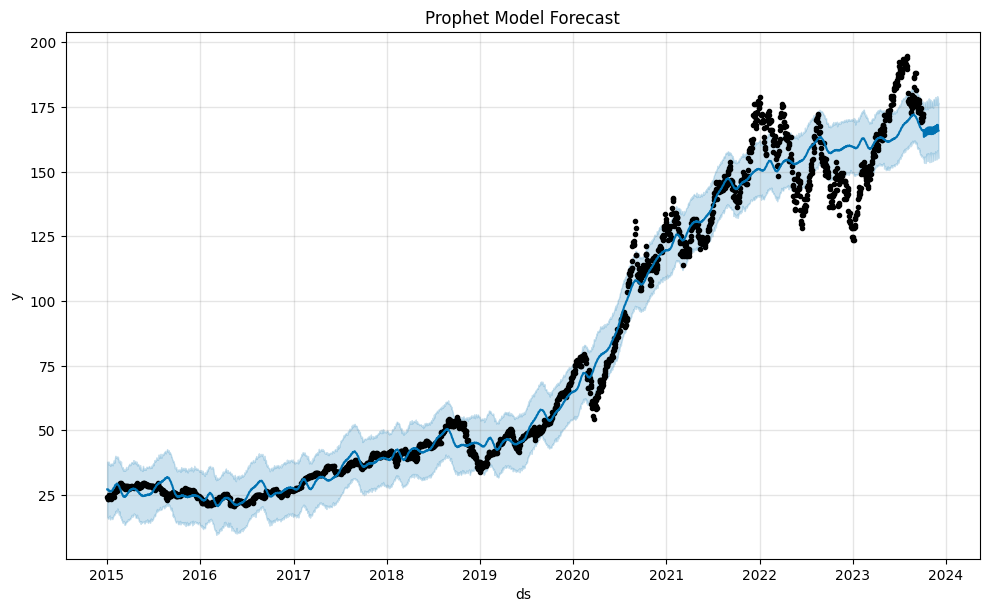

In [42]:
prophet_model.plot(prophet_forecast)
plt.title('Prophet Model Forecast')
plt.show()

#### Extract forecasts values for the test period
#### Ensure proper datetime alignment

In [43]:
prophet_test_forecast = prophet_forecast.set_index('ds')['yhat'][-60:]
prophet_test_forecast.index.freq = None

#### Plot Prophet forecasr vs actual

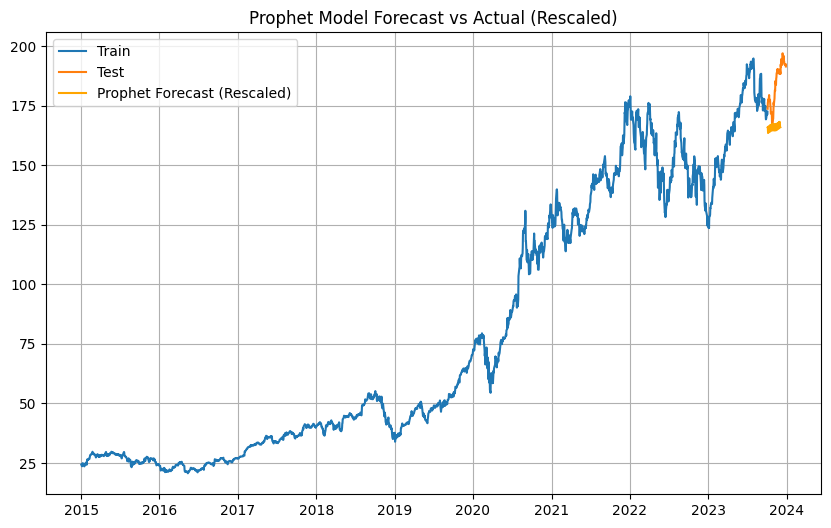

In [44]:
plt.figure(figsize=(10, 6))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(prophet_test_forecast, label='Prophet Forecast (Rescaled)', color='orange')
plt.title('Prophet Model Forecast vs Actual (Rescaled)')
plt.grid(True)
plt.legend()
plt.show()

#### Prophet MSE Calculation

In [45]:
prophet_mse = mean_squared_error(test, prophet_test_forecast)

In [46]:
print(f"Prophet Mean Squared Error: {prophet_mse}")

Prophet Mean Squared Error: 386.79453224609705
